<a href="https://colab.research.google.com/github/bkrant/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/DS_Unit_2_Sprint_Challenge_4_Practicing_Understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science Unit 2_
 
 # Sprint Challenge: Practicing & Understanding Predictive Modeling

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [26]:
train.drop_duplicates(train.columns[1:]).shape

(51907, 17)

In [16]:
train.shape

(51916, 17)

In [18]:
train.isnull().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [15]:
train.describe(exclude='number')

,DBA Name,AKA Name,Facility Type,Risk,Address,City,State,Inspection Date,Inspection Type,Violations,Location
count,51916,51293,51692,51904,51916,51863,51906,51916,51915,42261,51718
unique,17049,16350,329,3,13954,39,1,2257,51,42164,13410
top,SUBWAY,SUBWAY,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,2017-03-23T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,"{'longitude': '-87.91442843927047', 'latitude'..."
freq,654,802,34264,37731,741,51659,51906,50,24170,3,741


In [13]:
train.Fail.value_counts(normalize=True)

0    0.74139
1    0.25861
Name: Fail, dtype: float64

In [32]:
train['License #'].value_counts().head()

0.0          143
1354323.0     53
14616.0       53
1574001.0     33
1974745.0     21
Name: License #, dtype: int64

In [39]:
train.dtypes

Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Violations          object
Latitude           float64
Longitude          float64
Location            object
Fail                 int64
dtype: object

In [0]:
pd.to_numeric( train['Violations'].str.split('.').str[0] , downcast='float')

In [87]:
train['Zip'].value_counts().head()

60647.0    1782
60614.0    1756
60657.0    1676
60622.0    1670
60611.0    1663
Name: Zip, dtype: int64

In [0]:
train[train.columns[:-1]]

In [2]:
train.head(1)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1


In [0]:
def wrangle(df):
  df = df.copy()
  df = df.set_index('Inspection ID')
  df = df.drop(columns=['DBA Name','AKA Name','License #','Address','State','City','Latitude','Longitude','Location','Violations'])
  df = df.drop_duplicates()
  #df['Violations'] = pd.to_numeric( df['Violations'].str.split('.').str[0] , downcast='float')
  #df['Violations'] = df['Violations'].fillna(df['Violations'].mean())
  df = df.dropna(subset=['Zip'])
  X = df[df.columns[:-1]]
  y = df['Fail']
  return X, y

In [0]:
X_train, y_train = wrangle(train)
X_test, y_test   = wrangle(test)
pipe = make_pipeline( ce.OrdinalEncoder() )
X_train = pipe.fit_transform(X_train)
X_test  = pipe.transform(X_test)

In [144]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((51396, 5), (51396,), (17225, 5), (17225,))

In [145]:
X_train.dtypes

Facility Type        int64
Zip                float64
Inspection Date      int64
Inspection Type      int64
Violations         float32
dtype: object

In [146]:
X_train.head(2)

,Facility Type,Zip,Inspection Date,Inspection Type,Violations
Inspection ID,,,,,
2088270,1,60657.0,1,1,3.0
555268,2,60636.0,2,2,32.0


In [161]:
X_train.isna().sum()

Facility Type      0
Risk               0
Zip                0
Inspection Date    0
Inspection Type    0
dtype: int64

In [0]:
!pip install category_encoders

In [162]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_estimators': [100, 200], 
    'max_depth': [4, 10, None]
}

gridsearch = RandomizedSearchCV(
    RandomForestClassifier(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=18, 
    cv=3, 
    scoring='roc_auc', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 6 is smaller than n_iter=18. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   20.3s
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=18, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200], 'max_depth': [4, 10, None]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [163]:
results = pd.DataFrame(gridsearch.cv_results_)
print(f'Best result from search of {len(results)} parameter combinations')
results.sort_values(by='rank_test_score').head(1)

Best result from search of 6 parameter combinations


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
3,7.4357,0.104545,0.603787,0.046211,200,10,"{'n_estimators': 200, 'max_depth': 10}",0.684866,0.688665,0.690045,0.687859,0.00219,1,0.757024,0.754333,0.758668,0.756675,0.001787


In [164]:
gridsearch.best_estimator_.score(X_test, y_test)

0.7424842005788199

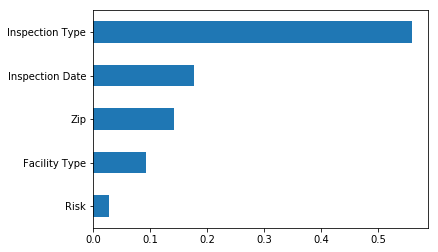

In [165]:

pd.Series(gridsearch.best_estimator_.feature_importances_, X_train.columns).sort_values().plot(kind='barh');

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?
- What is the "Learning Rate" and what is its function?

One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._

Gradient Descent seeks to minimize the cost function. The learning rate determines the size of the step along the path towards the minimum.